##Multi-label Genre Classification

Create a multi-label genre classification model using Tensorflow that automatically
assigns genre names looking at the summary of the movie.
1. Use pre-built embeddings for your data dictionary
2. Train the model using Transformer/Attention based architecture
3. Reach an overall “precision” score of 70%
4. Use TF serving to deploy the model as an API (on local)
5. Build a TF serving client to interact with the API. This client should also be able
to continuously accept data entered by the user and provide the genre for the
chat entered by the end-user.


Dataset - [CMU Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/)

Or download from - http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz


### Downloading the data

In [1]:
! wget http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz

--2023-05-18 07:06:16--  http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz
Resolving www.cs.cmu.edu (www.cs.cmu.edu)... 128.2.42.95
Connecting to www.cs.cmu.edu (www.cs.cmu.edu)|128.2.42.95|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48002242 (46M) [application/x-gzip]
Saving to: ‘MovieSummaries.tar.gz.2’

MovieSummaries.tar. 100%[===================>]  45.78M  2.10MB/s    in 33s     

2023-05-18 07:06:48 (1.40 MB/s) - ‘MovieSummaries.tar.gz.2’ saved [48002242/48002242]



In [2]:
! tar xvzf MovieSummaries.tar.gz

MovieSummaries/
MovieSummaries/tvtropes.clusters.txt
MovieSummaries/name.clusters.txt
MovieSummaries/plot_summaries.txt
MovieSummaries/README.txt
MovieSummaries/movie.metadata.tsv
MovieSummaries/character.metadata.tsv


## Importing necessary libraries for preprocessing and EDA

In [3]:
import pandas as pd

import nltk 
import matplotlib.pyplot as plt 
import seaborn as sns

In [4]:
! pwd

/content


### Data exploration and analysis on the movie meta data

In [5]:
movie_metadata = pd.read_csv("/content/MovieSummaries/movie.metadata.tsv", sep='\t')
movie_metadata.head()

,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
0,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
1,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
2,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
3,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"
4,13696889,/m/03cfc81,The Gangsters,1913-05-29,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen..."


In [6]:
#Naming all the Headers
movie_metadata_names=[ "Wikipedia movie ID",
                      "Freebase movie ID",
                      "Movie name",
                      "Movie release date",
                      "Movie box office revenue",
                      "Movie runtime",
                      "Movie languages",
                      "Movie countries",
                      "Movie genres"
                      ]

In [7]:
movie_metadata = pd.read_csv("/content/MovieSummaries/movie.metadata.tsv", sep='\t', names=movie_metadata_names)
movie_metadata.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [8]:
movie_metadata["Movie genres"] = movie_metadata["Movie genres"].map(lambda genres: list(eval(genres).values()))

In [9]:
movie_metadata.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Adventure,..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Mystery, Biographical film, Drama, Crime Drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","[Crime Fiction, Drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","[Thriller, Erotic thriller, Psychological thri..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}",[Drama]


### Adding the plot summarries

In [10]:
plot_summaries=pd.read_csv('/content/MovieSummaries/plot_summaries.txt',sep='\t',names=["Wikipedia movie ID","Plot Summary"])
plot_summaries.head()

,Wikipedia movie ID,Plot Summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


Since the plot summaries and movie metadata are not already sorted according to their movie ids, we have to merge the dataframe based on movie ids

### Merging the movie metadata and plot summaries based on Wikipedia movie ID

In [11]:
dataset = pd.merge(movie_metadata,plot_summaries,on="Wikipedia movie ID")
dataset.head()

,Wikipedia movie ID,Freebase movie ID,Movie name,Movie release date,Movie box office revenue,Movie runtime,Movie languages,Movie countries,Movie genres,Plot Summary
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}",[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,/m/04jcqvw,The Sorcerer's Apprentice,2002,NaN,86.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0hzlz"": ""South Africa""}","[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,/m/0gffwj,Little city,1997-04-04,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."


### Removing unnecessary data items from our data

In [12]:
#Dropping all the unwanted columns 
dataset=dataset.drop(
    columns=[
        "Freebase movie ID",
        "Movie name",
        "Movie release date",
        "Movie box office revenue",
        "Movie runtime",
        "Movie languages",
        "Movie countries"
        ])

In [13]:
dataset

,Wikipedia movie ID,Movie genres,Plot Summary
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","Set in the second half of the 22nd century, th..."
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",A series of murders of rich young women throug...
2,261236,[Drama],"Eva, an upper class housewife, becomes frustra..."
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","Every hundred years, the evil Morgana returns..."
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","Adam, a San Francisco-based artist who works a..."
...,...,...,...
42199,23851782,"[Crime Fiction, Thriller, Comedy, Supernatural]",{{plot}} The film opens with a Great Western e...
42200,35228177,[Drama],Two former National Oceanic Atmospheric Admini...
42201,34980460,"[Biographical film, Drama, Documentary]",{{No plot}} This film follows 12 years in the ...
42202,913762,"[Science Fiction, Japanese Movies, Adventure, ...","The story takes place in the year 2092,The Sup..."


In [14]:
dataset["Plot Summary"]=dataset["Plot Summary"].str.replace("{{No plot}}","")
dataset["Plot Summary"]=dataset["Plot Summary"].str.replace("{{plot}}","")
dataset["Plot Summary"]=dataset["Plot Summary"].str.lower()

<ipython-input-14-c58ce0386d9a>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Plot Summary"]=dataset["Plot Summary"].str.replace("{{No plot}}","")
<ipython-input-14-c58ce0386d9a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  dataset["Plot Summary"]=dataset["Plot Summary"].str.replace("{{plot}}","")


In [15]:
dataset

,Wikipedia movie ID,Movie genres,Plot Summary
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","set in the second half of the 22nd century, th..."
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",a series of murders of rich young women throug...
2,261236,[Drama],"eva, an upper class housewife, becomes frustra..."
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","every hundred years, the evil morgana returns..."
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","adam, a san francisco-based artist who works a..."
...,...,...,...
42199,23851782,"[Crime Fiction, Thriller, Comedy, Supernatural]",the film opens with a great western express s...
42200,35228177,[Drama],two former national oceanic atmospheric admini...
42201,34980460,"[Biographical film, Drama, Documentary]",this film follows 12 years in the lives of 3 ...
42202,913762,"[Science Fiction, Japanese Movies, Adventure, ...","the story takes place in the year 2092,the sup..."


In [16]:
dataset.isnull().sum()

Wikipedia movie ID    0
Movie genres          0
Plot Summary          0
dtype: int64

### Visualising the genres by plotting a bar graph and a word cloud

In [17]:
genres = dataset['Movie genres']

In [18]:
print(genres)

0        [Thriller, Science Fiction, Horror, Adventure,...
1        [Thriller, Erotic thriller, Psychological thri...
2                                                  [Drama]
3          [Family Film, Fantasy, Adventure, World cinema]
4        [Romantic comedy, Ensemble Film, Comedy-drama,...
                               ...                        
42199      [Crime Fiction, Thriller, Comedy, Supernatural]
42200                                              [Drama]
42201              [Biographical film, Drama, Documentary]
42202    [Science Fiction, Japanese Movies, Adventure, ...
42203                    [Thriller, Horror, Slasher, Teen]
Name: Movie genres, Length: 42204, dtype: object


In [19]:
all_genres = sum(genres,[])
len(set(all_genres))

363

In [20]:
print(all_genres)

['Thriller', 'Science Fiction', 'Horror', 'Adventure', 'Supernatural', 'Action', 'Space western', 'Thriller', 'Erotic thriller', 'Psychological thriller', 'Drama', 'Family Film', 'Fantasy', 'Adventure', 'World cinema', 'Romantic comedy', 'Ensemble Film', 'Comedy-drama', 'Drama', 'Comedy', 'Romantic drama', 'Romance Film', 'Costume drama', 'War film', 'Epic', 'Period piece', 'Drama', 'Film adaptation', 'Comedy', 'Science Fiction', 'Adventure', 'Animation', 'Short Film', 'Fantasy', 'Family Film', 'Action', "Children's/Family", 'Musical', 'Fantasy', 'Comedy', 'Drama', 'Family Film', "Children's Fantasy", 'Romantic comedy', 'Romance Film', 'Comedy', 'Indie', 'Romance Film', 'Crime Fiction', 'Drama', 'Coming of age', 'Family Film', 'Comedy', 'Action', 'World cinema', 'Musical', 'Drama', 'Romantic drama', 'Romance Film', 'Bollywood', 'Drama', 'Romantic comedy', 'Romance Film', 'Comedy', 'World cinema', 'Indie', 'Drama', 'Comedy', 'Fan film', 'Short Film', 'Indie', 'Black comedy', 'Comedy', '

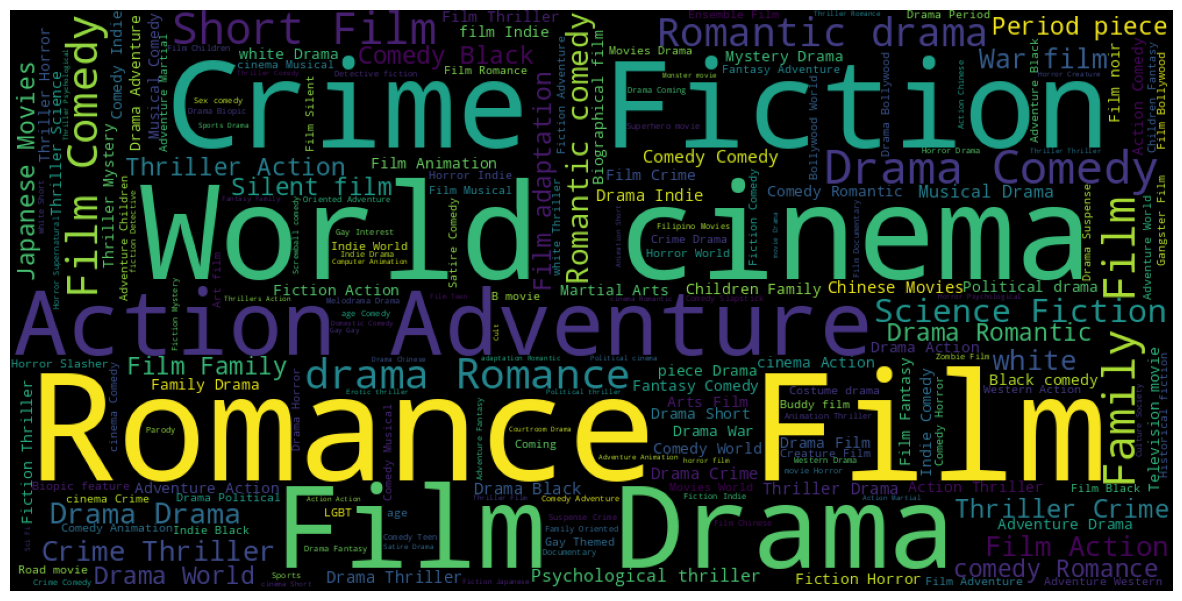

In [21]:
from wordcloud import WordCloud


unique_string = (" ").join(all_genres)
wordcloud = WordCloud(width = 1000, height = 500).generate(unique_string)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("genres_cloud"+".png", bbox_inches='tight')
plt.show()
plt.close()

In [22]:
all_genres = nltk.FreqDist(all_genres)
genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 'Count': list (all_genres.values())})
genres_df.head()

,Genre,Count
0,Thriller,6530
1,Science Fiction,2339
2,Horror,4082
3,Adventure,3248
4,Supernatural,571


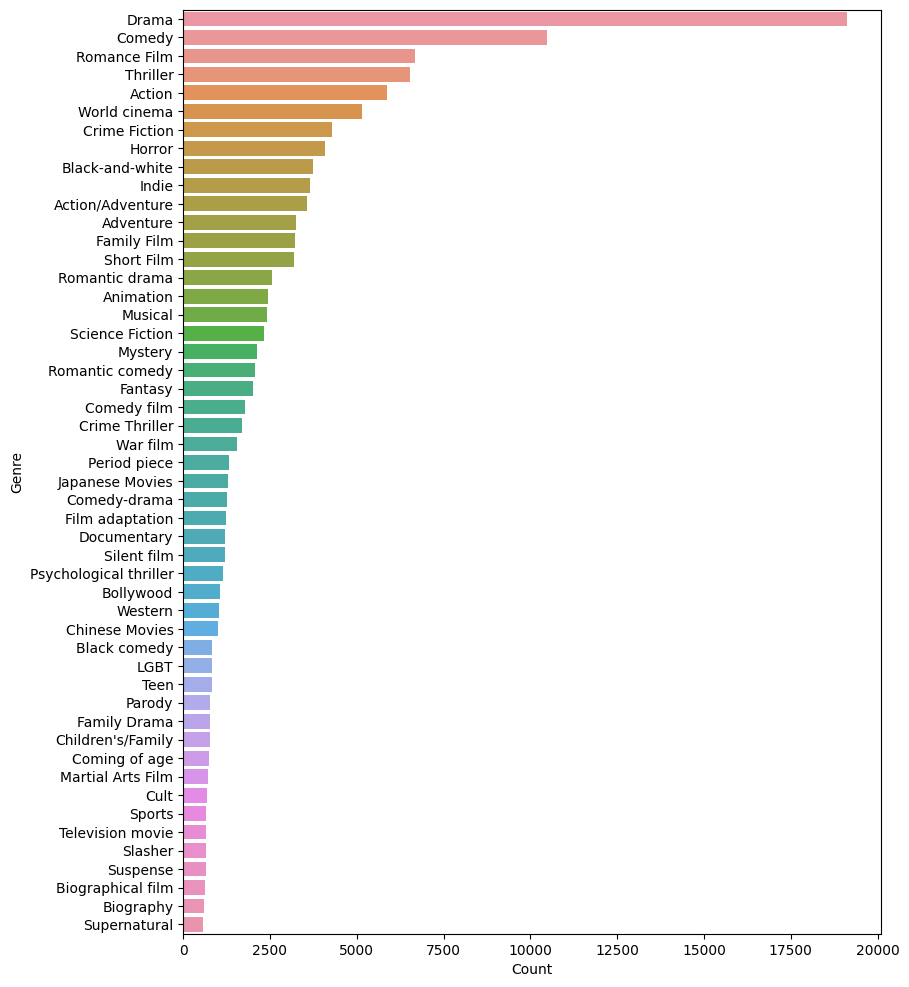

In [23]:
g = genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(9,12)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Genre') 
plt.savefig("distribution"+".png", bbox_inches='tight')
plt.show()

In [24]:
movie_genres = dataset['Movie genres']
movie_genres

0        [Thriller, Science Fiction, Horror, Adventure,...
1        [Thriller, Erotic thriller, Psychological thri...
2                                                  [Drama]
3          [Family Film, Fantasy, Adventure, World cinema]
4        [Romantic comedy, Ensemble Film, Comedy-drama,...
                               ...                        
42199      [Crime Fiction, Thriller, Comedy, Supernatural]
42200                                              [Drama]
42201              [Biographical film, Drama, Documentary]
42202    [Science Fiction, Japanese Movies, Adventure, ...
42203                    [Thriller, Horror, Slasher, Teen]
Name: Movie genres, Length: 42204, dtype: object

### One hot encoding the genres

In [25]:
dataset = dataset.join(movie_genres.str.join('|').str.get_dummies())

In [26]:
dataset.head()

,Wikipedia movie ID,Movie genres,Plot Summary,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,975900,"[Thriller, Science Fiction, Horror, Adventure,...","set in the second half of the 22nd century, th...",0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9363483,"[Thriller, Erotic thriller, Psychological thri...",a series of murders of rich young women throug...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,261236,[Drama],"eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,18998739,"[Family Film, Fantasy, Adventure, World cinema]","every hundred years, the evil morgana returns...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,6631279,"[Romantic comedy, Ensemble Film, Comedy-drama,...","adam, a san francisco-based artist who works a...",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
print(dataset.columns)

Index(['Wikipedia movie ID', 'Movie genres', 'Plot Summary', 'Absurdism',
       'Acid western', 'Action', 'Action Comedy', 'Action Thrillers',
       'Action/Adventure', 'Addiction Drama',
       ...
       'Werewolf fiction', 'Western', 'Whodunit', 'Women in prison films',
       'Workplace Comedy', 'World History', 'World cinema', 'Wuxia', 'Z movie',
       'Zombie Film'],
      dtype='object', length=366)


In [28]:
dataset = dataset.drop(['Movie genres', 'Wikipedia movie ID'], axis=1)

In [29]:
dataset.head()

,Plot Summary,Absurdism,Acid western,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,...,Werewolf fiction,Western,Whodunit,Women in prison films,Workplace Comedy,World History,World cinema,Wuxia,Z movie,Zombie Film
0,"set in the second half of the 22nd century, th...",0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,a series of murders of rich young women throug...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"every hundred years, the evil morgana returns...",0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,"adam, a san francisco-based artist who works a...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
columns = dataset.columns

In [31]:
genre_names = columns[1:]
threshold = 20
for name in genre_names:
    if dataset[name].value_counts()[1]<=threshold:
        dataset=dataset.drop(name,axis=1)

In [32]:
columns = dataset.columns

In [33]:
dataset.head()

,Plot Summary,Absurdism,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,Adventure Comedy,...,Tollywood,Tragedy,Tragicomedy,War film,Western,Whodunit,Workplace Comedy,World cinema,Wuxia,Zombie Film
0,"set in the second half of the 22nd century, th...",0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,a series of murders of rich young women throug...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"every hundred years, the evil morgana returns...",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,"adam, a san francisco-based artist who works a...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Consolidating all one hot encoded labels to a single label for ease of usage

In [34]:
dataset['label'] = dataset[dataset.columns[1:]].values.tolist()
dataset

,Plot Summary,Absurdism,Action,Action Comedy,Action Thrillers,Action/Adventure,Addiction Drama,Adult,Adventure,Adventure Comedy,...,Tragedy,Tragicomedy,War film,Western,Whodunit,Workplace Comedy,World cinema,Wuxia,Zombie Film,label
0,"set in the second half of the 22nd century, th...",0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,a series of murders of rich young women throug...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"eva, an upper class housewife, becomes frustra...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"every hundred years, the evil morgana returns...",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,"adam, a san francisco-based artist who works a...",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42199,the film opens with a great western express s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42200,two former national oceanic atmospheric admini...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42201,this film follows 12 years in the lives of 3 ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42202,"the story takes place in the year 2092,the sup...",0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [35]:
dataset = dataset[['Plot Summary', 'label']].copy()
dataset

,Plot Summary,label
0,"set in the second half of the 22nd century, th...","[0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1,a series of murders of rich young women throug...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"eva, an upper class housewife, becomes frustra...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"every hundred years, the evil morgana returns...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,"adam, a san francisco-based artist who works a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
42199,the film opens with a great western express s...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42200,two former national oceanic atmospheric admini...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42201,this film follows 12 years in the lives of 3 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42202,"the story takes place in the year 2092,the sup...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [36]:
dataset=dataset.convert_dtypes()

In [37]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42204 entries, 0 to 42203
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Plot Summary  42204 non-null  string
 1   label         42204 non-null  object
dtypes: object(1), string(1)
memory usage: 2.0+ MB


Splitting the data into training and validation set

In [38]:
train=dataset.sample(frac=0.8)
val= dataset.drop(train.index)

In [39]:
train

,Plot Summary,label
37496,gangaram alias ganga ([[govinda lives a simpl...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
15414,oswald comes out of his house carrying a bowl ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
30577,the bosses of the european drug cartel meet in...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
13875,jack lane joins the australian navy and trains...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
40833,how to be a serial killer is the story of mike...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
24369,take me out to the ball game is a period piec...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
22377,leopoldo is a separate teacher and comes to k...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
25694,ben stein introduces the film as a long-lost f...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
32320,"during the vietnam war in 1968, captain sam ca...","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, ..."


In [40]:
val

,Plot Summary,label
1,a series of murders of rich young women throug...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,{{plot|dateact 1act 2act 3act 4act 5 finally n...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,"otto brosowski, a communist miner, writes to t...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
26,"randy bodek is a rebellious college slacker, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28,the film focuses on the conflict between maxim...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
42176,a daytime soap opera star has to deal with his...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42180,the story is set in africa. two rival european...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42187,"in september 1998, at the end of the balkan wa...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
42194,havoc is wrought on the inhabitants of a small...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."


In [41]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing necessary libraries for prediction

In [42]:
import tensorflow as tf 
import tensorflow_text as text
import tensorflow_hub as hub

import os

### Creating the dataset

In [43]:
train_list=train["Plot Summary"].to_list()
val_list=val["Plot Summary"].to_list()

ytrain_list=train["label"].to_list()
yval_list=val["label"].to_list()

In [44]:
train_ds=tf.data.Dataset.from_tensor_slices((train_list,ytrain_list))
val_ds =tf.data.Dataset.from_tensor_slices((val_list,yval_list))

In [45]:
train_ds = train_ds.shuffle(10000).batch(16, drop_remainder=True)
val_ds = val_ds.shuffle(10000).batch(16, drop_remainder=True)

### Defining the model

I am using small bert for this,
where it has
8 layers,
has a dimensionality/hidden size of 512 and
8 attention heads.


In [46]:
preprocessor = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/2",
    trainable=False)

In [47]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = preprocessor(text_input)
outputs = encoder(preprocessed_text)

l = tf.keras.layers.Dropout(0.65, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(213, activation='sigmoid', name="output")(l)

model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

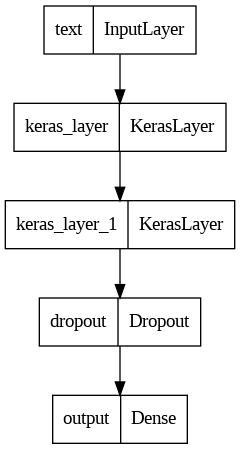

In [49]:
from keras.utils import plot_model
plot_model(model)

### Compiling the model

In [50]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


# Compiling the model with adam optimizers and binary crossentropy as loss
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

### Adding checkpoints

In [51]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_filepath = 'best_model.h5'
checkpoint = ModelCheckpoint(
    checkpoint_filepath, 
    monitor='val_precision', 
    save_best_only=True, 
    mode='max', 
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_precision",
    patience=7,
    verbose=1,
    mode="max",
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_precision",
    factor=0.01,
    patience=4,
    verbose=1,
    mode="max",
    min_delta=0.0001
)

### Training the model

In [ ]:
history = model.fit(train_ds,validation_data=val_ds, epochs=20, callbacks=[checkpoint, early_stop, reduce_lr])

Epoch 1/20
2110/2110 [==============================] - ETA: 0s - loss: 0.0661 - accuracy: 0.9821 - precision: 0.3549 - recall: 0.0923
Epoch 1: val_precision improved from -inf to 0.71588, saving model to best_model.h5
2110/2110 [==============================] - 230s 105ms/step - loss: 0.0661 - accuracy: 0.9821 - precision: 0.3549 - recall: 0.0923 - val_loss: 0.0563 - val_accuracy: 0.9837 - val_precision: 0.7159 - val_recall: 0.0510 - lr: 0.0010
Epoch 2/20
2110/2110 [==============================] - ETA: 0s - loss: 0.0589 - accuracy: 0.9836 - precision: 0.5387 - recall: 0.1095
Epoch 2: val_precision improved from 0.71588 to 0.71634, saving model to best_model.h5
2110/2110 [==============================] - 248s 118ms/step - loss: 0.0589 - accuracy: 0.9836 - precision: 0.5387 - recall: 0.1095 - val_loss: 0.0550 - val_accuracy: 0.9838 - val_precision: 0.7163 - val_recall: 0.0546 - lr: 0.0010
Epoch 3/20
2110/2110 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.98

The best precision achieved is 0.75070

### Exporting the model to a tensorflow saved model format

In [53]:
version=1
export_path = os.path.join("/content/model", str(version))
tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

### Installing tensorflow model server and tensorflow serving api

In [54]:
import sys

if "google.colab" in sys.modules:
    url = "https://storage.googleapis.com/tensorflow-serving-apt"
    src = "stable tensorflow-model-server tensorflow-model-server-universal"
    !echo 'deb {url} {src}' > /etc/apt/sources.list.d/tensorflow-serving.list
    !curl '{url}/tensorflow-serving.release.pub.gpg' | apt-key add -
    !apt update -q && apt-get install -y tensorflow-model-server
    !pip install -q -U tensorflow-serving-api

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0  35890      0 --:--:-- --:--:-- --:--:-- 35457
OK
Get:1 https://storage.googleapis.com/tensorflow-serving-apt stable InRelease [3,026 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:3 http://archive.ubuntu.com/ubuntu focal InRelease
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:6 https://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server amd64 Packages [338 B]
Get:7 https://storage.googleapis.com/tensorflow-serving-apt stable/tensorflow-model-server-universal amd64 Packages [348 B]
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubunt

In [55]:
!saved_model_cli show --dir '/content/model/1/' --tag_set serve \
                      --signature_def serving_default

2023-05-18 07:47:14.262572: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
The given SavedModel SignatureDef contains the following input(s):
  inputs['text'] tensor_info:
      dtype: DT_STRING
      shape: (-1)
      name: serving_default_text:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 213)
      name: StatefulPartitionedCall_1:0
Method name is: tensorflow/serving/predict


In [56]:
os.environ["MODEL_DIR"] = "/content/model/"

In [58]:
!zip -r /content/model.zip /content/model
from google.colab import files
files.download("/content/model.zip")

  adding: content/model/ (stored 0%)
  adding: content/model/1/ (stored 0%)
  adding: content/model/1/keras_metadata.pb (deflated 84%)
  adding: content/model/1/variables/ (stored 0%)
  adding: content/model/1/variables/variables.index (deflated 78%)
  adding: content/model/1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/model/1/assets/ (stored 0%)
  adding: content/model/1/assets/vocab.txt (deflated 53%)
  adding: content/model/1/saved_model.pb (deflated 92%)
  adding: content/model/1/fingerprint.pb (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Starting the server on our local machine

In [59]:
%%bash --bg 
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=multilabel_model \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

In [60]:
! tail server.log

### Testing our model on 4 random movies

The movies are Kung Fu Panda 1, Avengers: Endgame, 3 Idiots, Harry Potter: The Philosopher's Stone

In [61]:
kung_fu_panda = "In Ancient China's Valley of Peace, Po, a giant panda, helps run his adoptive father's noodle restaurant. He dreams of fighting with the kung fu masters, the Furious Five, and becoming the Dragon Warrior. Master Oogway predicts the escape of Shifu's former protégé Tai Lung and his attack on the valley to obtain the Dragon Scroll. Oogway holds a tournament to identify the Dragon Warrior, and Po, who arrives late, is accidentally proclaimed as the hero. Shifu tries to dispose of Po with harsh training, while the Furious Five dismiss him as an enthusiast. Despite his difficulties, Po endures his training, befriends the Five, and discovers Shifu's shame over Tai Lung's betrayal. Tai Lung escapes from prison, and Po is finally trained in kung fu using his love for food as motivation. The Furious Five fight Tai Lung but are defeated, and Po receives the Dragon Scroll, which turns out to be blank. Mr. Ping reveals the message of the Scroll, and Po returns to help Shifu. Tai Lung is defeated using the Wuxi Finger Hold technique, and Po becomes the Dragon Warrior, gaining the respect of the Furious Five. In the end, Shifu and Po share a meal while a peach tree grows in the background."
avengers_endgame = "In 2018, Carol Danvers rescues Tony Stark and Nebula, reuniting with the remaining Avengers. They plan to reverse Thanos' actions using the destroyed Infinity Stones but find Thanos decapitated by Thor. Five years later, Scott Lang escapes the Quantum Realm and proposes time travel to retrieve the Stones. Stark, Rocket, and Banner build a time machine. They recruit an overweight Thor and a vigilante Clint Barton. The team splits up to different points in time to retrieve the Stones. Banner gets the Time Stone from the Ancient One, Rogers retrieves the Mind Stone, and Stark encounters his father, Howard. Rocket and Thor extract the Reality Stone, while Barton and Romanoff travel to Vormir. Romanoff sacrifices herself, allowing Barton to obtain the Soul Stone. Back in the present, they use the Stones to reverse Thanos' disintegrations. However, 2014-Thanos arrives with his army. The Avengers, along with other allies, fight against Thanos. Danvers destroys Thanos' warship, but Thanos overpowers her. Stark sacrifices himself to disintegrate Thanos and his army. After the funeral, Thor joins the Guardians, Valkyrie becomes the new ruler of New Asgard, and Rogers remains in the past with Carter. In the present, an elderly Rogers passes his shield to Sam Wilson."
three_idiots = "Farhan, Raju, and Rancho are college roommates at Imperial College of Engineering. Rancho challenges the college director, Virus, over the extreme pressure on students. They crash Virus's daughter's wedding, leading to unexpected connections. Rancho helps Raju's father during a health crisis, and their friendship is restored. Despite ranking last, Rancho excels while Farhan pursues photography and Raju gains self-confidence. They expose Virus's unfair practices but get expelled. Pia confronts her father, and the group helps deliver Mona's baby during a storm. Virus acknowledges Rancho's brilliance and revokes the expulsions. Ten years later, they search for Rancho and discover his true identity as Phunsukh Wangdu, a successful inventor. Chatur, who mocked Rancho, accepts defeat."
harry_potter_1 = "Late one night, professors Albus Dumbledore and Minerva McGonagall, along with Rubeus Hagrid, deliver orphaned wizard Harry Potter to his Muggle relatives, the Dursleys. Ten years later, Harry receives a letter of acceptance to Hogwarts School of Witchcraft and Wizardry, but the Dursleys try to prevent him from reading it. Hagrid intervenes, revealing Harry's magical heritage and the truth about his parents' murder by Lord Voldemort. At Hogwarts, Harry befriends Ron Weasley and Hermione Granger, while developing a rivalry with Draco Malfoy. He excels in flying and joins Gryffindor's Quidditch team as the youngest Seeker in a century. Harry, Ron, and Hermione stumble upon Fluffy, a three-headed dog guarding the philosopher's stone. Suspecting Severus Snape's intentions, the trio embarks on a quest to find the stone before him. They overcome various obstacles, including Devil's Snare, flying keys, and a giant chess game. In the end, they encounter Quirinus Quirrell, who is possessed by Voldemort. During the confrontation, Harry's love-based protection saves him, and Quirrell is defeated, resulting in the destruction of the stone. Dumbledore awards house points to Gryffindor, and Harry returns to the Dursleys with a newfound sense of belonging at Hogwarts."

In [62]:
import json


request_json = json.dumps({
    "signature_name": "serving_default",
    "instances": [kung_fu_panda, avengers_endgame, three_idiots, harry_potter_1],
})

In [64]:
import requests
headers = {"content-type": "application/json"}
json_response = requests.post('http://localhost:8501/v1/models/multilabel_model:predict', data=request_json, headers=headers)
predictions = json.loads(json_response.text)

### Printing the predictions

In [65]:
predictions

{'predictions': [[0.00115315965,
   0.252109945,
   0.00402188813,
   0.0054847,
   0.227818087,
   9.21032624e-05,
   0.000540781359,
   0.15505299,
   0.00182597351,
   0.00015218764,
   0.000139426134,
   0.00106163963,
   0.00047344144,
   0.000341097126,
   0.00148119696,
   0.0537753627,
   0.00609888881,
   9.79499382e-05,
   4.27192317e-05,
   4.1865962e-05,
   0.00281103258,
   0.000125208506,
   0.000145529571,
   0.00107722916,
   0.00574821327,
   0.00803559087,
   0.00304457382,
   0.0060087149,
   0.0472982191,
   0.0005175923,
   0.0174788311,
   0.00148255448,
   0.00739463745,
   0.000160049065,
   0.000268614443,
   0.00112564606,
   0.00897674914,
   0.00316916383,
   0.0266567692,
   0.141482949,
   0.0002587341,
   0.000253728562,
   0.00044398618,
   0.272437423,
   0.000150522625,
   0.000219807684,
   0.0191650819,
   0.00145586953,
   0.00062599458,
   0.0252496358,
   0.00789638329,
   0.00410648808,
   0.000871820317,
   2.64368373e-05,
   0.0109040765,
   0.

In [66]:
print(type(predictions))

<class 'dict'>


In [67]:
genre = columns[1:]

### Printing the genres for the movies

In [68]:
for i in range(len(predictions['predictions'])):
  indices = [i for i, val in enumerate(predictions['predictions'][i]) if float(val) > 0.2]
  for ind in indices:
    print(genre[ind], end="\n")
  print("\n")

Action
Action/Adventure
Comedy
Drama


Action
Action/Adventure
Adventure
Fantasy
Horror
Science Fiction


Comedy
Drama


Black-and-white
Comedy
Drama
Family Film
Horror




### Testing the validation loss, accuracy and most importantly the precision of our model.

In [71]:
validation_loss, validation_accuracy, validation_precision, _ = model.evaluate(val_ds)

527/527 [==============================] - 50s 94ms/step - loss: 0.0550 - accuracy: 0.9838 - precision: 0.7166 - recall: 0.0546


In [72]:
# Print the validation loss, acuuracy, precision
print("Validation Loss: {:.2f}%".format(validation_loss * 100))
print("Validation Accuracy: {:.2f}%".format(validation_accuracy * 100))
print("Validation Precision: {:.2f}%".format(validation_precision * 100))

Validation Loss: 5.50%
Validation Accuracy: 98.38%
Validation Precision: 71.66%
